#the link of data
https://www.kaggle.com/datasets/khoongweihao/covid19-xray-dataset-train-test-sets/data

# Import the libraries

In [ ]:
#import the important libraries
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import PIL
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,MaxPooling2D,Conv2D,Dropout,Activation,BatchNormalization
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report,confusion_matrix
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings('ignore')
import zipfile
import matplotlib.pyplot as plt
import numpy as np


#Load the data from kaggel

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d khoongweihao/covid19-xray-dataset-train-test-sets

 95% 80.0M/84.3M [00:00<00:00, 187MB/s]
100% 84.3M/84.3M [00:00<00:00, 159MB/s]


In [ ]:
#extract the zip fill of data
zip_ref = zipfile.ZipFile('/content/covid19-xray-dataset-train-test-sets.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

# creat the data to train and validation sets

In [ ]:
train = keras.utils.image_dataset_from_directory(
    directory = '/content/xray_dataset_covid19/train',
    labels='inferred',
    label_mode = 'int',
    batch_size=148,
    image_size=(256,256)
)

validation = keras.utils.image_dataset_from_directory(
    directory = '/content/xray_dataset_covid19/test',
    labels='inferred',
    label_mode = 'int',
    batch_size=40,
    image_size=(256,256)
)

Found 148 files belonging to 2 classes.
Found 40 files belonging to 2 classes.


In [ ]:
import tensorflow as tf

# Load a batch of images from the training dataset
for images, labels in train:
    input_shape = images.shape[1:]  # Exclude batch size dimension
    break

print("Input shape for the model:", input_shape)


Input shape for the model: (256, 256, 3)


In [ ]:
#show the class inside the sets
train_dir = ('/content/xray_dataset_covid19/train')
validation_dir = ('/content/xray_dataset_covid19/test')
classes_train =os.listdir(train_dir)
classes_val =os.listdir(validation_dir)
classes_train
classes_val

['PNEUMONIA', 'NORMAL']

# Data augmentation and preprocessing

In [ ]:
# Data augmentation parameters
train_datagen = ImageDataGenerator(
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.12,
    fill_mode='constant',cval=125,
    brightness_range=[0.7, 1.3])



train_generator=train_datagen.flow_from_directory(
    train_dir,
    class_mode='binary',
    color_mode='rgb',
    batch_size= 148,
    target_size=(256, 256)
)

val_datagen = ImageDataGenerator(
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.12,
    fill_mode='constant',cval=125,
    brightness_range=[0.7, 1.3])


val_generator=val_datagen.flow_from_directory(
    validation_dir,
    class_mode='binary',
    color_mode='rgb',
    batch_size=40,
    target_size=(256, 256)
)

# val_generator=ImageDataGenerator(rescale=1./255)

Found 148 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [ ]:
#ensure from the imbalanced data
class_weights = {}
total_samples = train_generator.samples
num_classes = len(train_generator.class_indices)
class_counts = np.bincount(train_generator.classes)
for i in range(num_classes):
    class_weights[i] = total_samples / (num_classes * class_counts[i])

print(class_counts)

[74 74]


# CNN Model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 255, 255, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 41, 41, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 107584)            0         
                                                                 
 dropout (Dropout)           (None, 107584)            0

<Axes: >

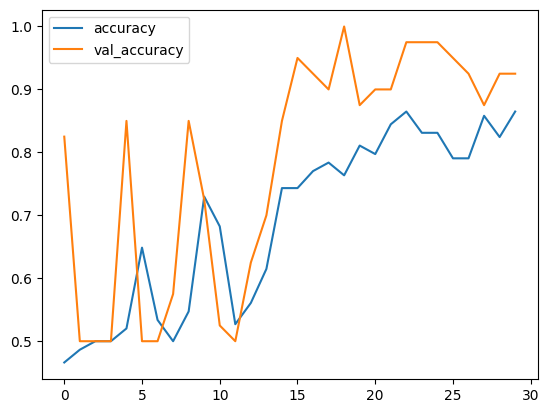

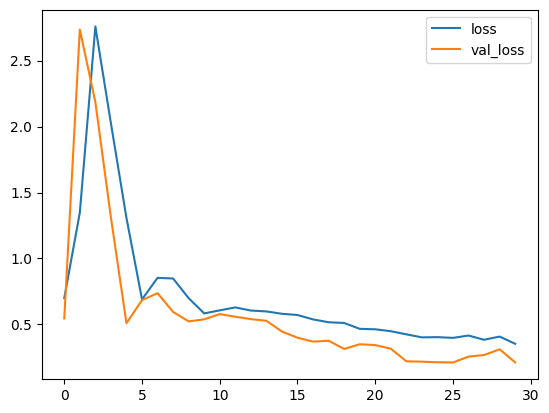

In [ ]:
tf.random.set_seed(42)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# build the model
model=Sequential()

model.add(Conv2D(32,(2,2),activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(3,3))

model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(64,activation='relu'))

model.add(Dropout(0.4))
model.add(Dense(1,activation='sigmoid'))

#compile the model
model.compile(optimizer='adam' ,loss='binary_crossentropy',metrics=['accuracy'])


# Display model summary
model.summary()

#fit the model
history=model.fit_generator(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    verbose=1,
    shuffle=False

)

#plot the accurcy
losses = pd.DataFrame(model.history.history)
losses[['accuracy','val_accuracy']].plot()
losses[['loss','val_loss']].plot()